In [17]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from transformers import pipeline

In [2]:
reviews = np.load('data/reviews.npz')
X, y = reviews['X'], reviews['y'] - 1

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=109)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((439864, 1093),
 (439864,),
 (109967, 1093),
 (109967,),
 (137458, 1093),
 (137458,))

In [6]:
batch_size = 1024
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(len(X_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(len(X_test)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
with open('data/word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)
word2idx

{'.hes': 1,
 'chick-flick': 2,
 'amanduhhh': 3,
 'makkeoli': 4,
 'discounted/free': 5,
 'ruedas.': 6,
 'gaaahlic': 7,
 '//www.picniceats.com/daily-specials/': 8,
 'fish..not': 9,
 'assented': 10,
 'spontaneous': 11,
 'pounded-thin': 12,
 'bar-restaurants': 13,
 'service..we': 14,
 'assurance': 15,
 'american-styled': 16,
 'cheesesteak..no': 17,
 'seatimg': 18,
 'topo': 19,
 'latvia.': 20,
 'psycology': 21,
 '+butter': 22,
 'pho-loving': 23,
 'foxtrot.': 24,
 'handcart': 25,
 'private/intimate': 26,
 'incuded': 27,
 '46.281': 28,
 'mousse/pudding': 29,
 "'06": 30,
 'redness.': 31,
 'down-good': 32,
 '9:25pm': 33,
 'albariño.': 34,
 'selfish/hungry': 35,
 'obeying': 36,
 'stalin': 37,
 'w/bug.': 38,
 'hasty': 39,
 'v.2': 40,
 'visor.': 41,
 'askew': 42,
 'onpoint': 43,
 'lnever': 44,
 'bar/atmosphere.': 45,
 'lasorda': 46,
 'waitress/chef.': 47,
 '~wolaver': 48,
 'oft-used': 49,
 'newyear': 50,
 'kenzie': 51,
 'cenato': 52,
 '.avoid.': 53,
 'decorated': 54,
 'fluctuated.': 55,
 'setan': 

In [9]:
idx2word = {v: k for k,v in word2idx.items()}

## Baseline Models

### Naive Feed Forward Network

In [10]:
model1 = Sequential(name='Naive_FFNN')
model1.add(Dense(64, activation='relu',input_dim=X_train.shape[1]))
model1.add(Dense(5, activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "Naive_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                70016     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 70,341
Trainable params: 70,341
Non-trainable params: 0
_________________________________________________________________


In [11]:
epochs=10
model1.fit(train_data, validation_data=val_data, epochs=epochs)

Epoch 1/10


2023-04-23 01:40:54.330512: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


430/430 [==============================] - 10s 14ms/step - loss: 4254.0840 - accuracy: 0.3693 - val_loss: 17.7415 - val_accuracy: 0.3968
Epoch 2/10
430/430 [==============================] - 11s 16ms/step - loss: 9.6664 - accuracy: 0.4013 - val_loss: 6.8973 - val_accuracy: 0.3992
Epoch 3/10
430/430 [==============================] - 5s 7ms/step - loss: 4.6413 - accuracy: 0.4026 - val_loss: 4.3717 - val_accuracy: 0.3998
Epoch 4/10
430/430 [==============================] - 4s 7ms/step - loss: 3.0913 - accuracy: 0.4029 - val_loss: 3.0873 - val_accuracy: 0.3999
Epoch 5/10
430/430 [==============================] - 6s 9ms/step - loss: 2.3346 - accuracy: 0.4029 - val_loss: 2.3908 - val_accuracy: 0.3999
Epoch 6/10
430/430 [==============================] - 5s 8ms/step - loss: 1.9611 - accuracy: 0.4030 - val_loss: 2.0686 - val_accuracy: 0.4000
Epoch 7/10
430/430 [==============================] - 5s 7ms/step - loss: 1.7651 - accuracy: 0.4030 - val_loss: 1.8679 - val_accuracy: 0.4000
Epoch 8/1

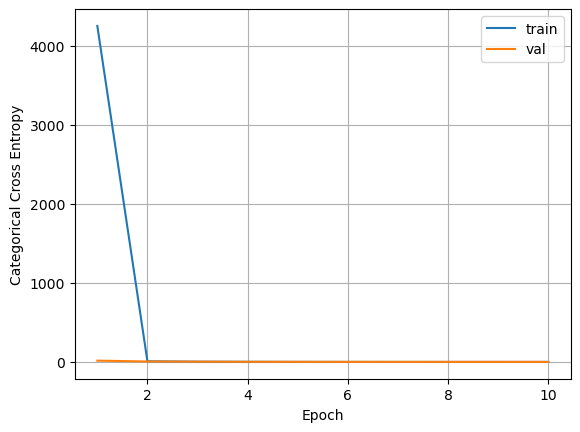

In [12]:
plt.plot(range(1, 11), model1.history.history['loss'], label='train')
plt.plot(range(1, 11), model1.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.legend()
plt.grid()
plt.show()

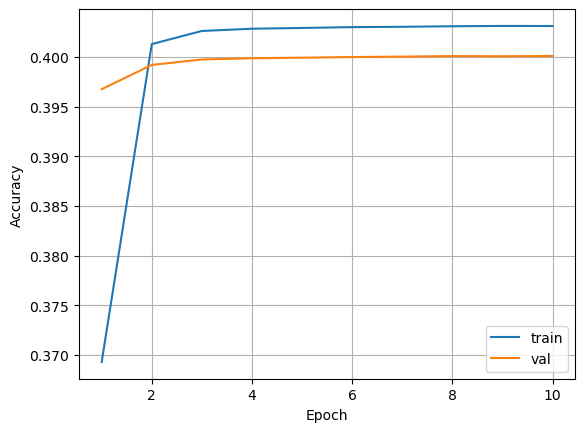

In [14]:
plt.plot(range(1, 11), model1.history.history['accuracy'], label='train')
plt.plot(range(1, 11), model1.history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [24]:
model1.evaluate(test_data)

135/135 [==============================] - 2s 6ms/step - loss: 1.6745 - accuracy: 0.4058


[1.6744630336761475, 0.4057603180408478]

### LSTM

In [5]:
inputs = Input(shape=(X_train.shape[1],))
n = Embedding(len(word2idx) + 1, 32, mask_zero=True)(inputs)
n = LSTM(32)(n)
outputs = Dense(5, activation='softmax')(n)
model2 = Model(inputs=inputs, outputs=outputs, name="LSTM")
model2.summary()
model2.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

2023-04-20 12:55:23.879783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1093)]            0         
                                                                 
 embedding (Embedding)       (None, 1093, 32)          11687808  
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 11,696,293
Trainable params: 11,696,293
Non-trainable params: 0
_________________________________________________________________


In [7]:
model2.fit(train_data, validation_data=val_data, epochs=epochs)

Epoch 1/10
68/68 [==============================] - 305s 4s/step - loss: 1.4336 - accuracy: 0.3985 - val_loss: 1.2185 - val_accuracy: 0.4242
Epoch 2/10
68/68 [==============================] - 291s 4s/step - loss: 1.1347 - accuracy: 0.4852 - val_loss: 1.0741 - val_accuracy: 0.5087
Epoch 3/10
68/68 [==============================] - 294s 4s/step - loss: 0.9950 - accuracy: 0.5457 - val_loss: 0.9883 - val_accuracy: 0.5553
Epoch 4/10
68/68 [==============================] - 283s 4s/step - loss: 0.8819 - accuracy: 0.6109 - val_loss: 0.9520 - val_accuracy: 0.5835
Epoch 5/10
68/68 [==============================] - 2948s 44s/step - loss: 0.7920 - accuracy: 0.6623 - val_loss: 0.9188 - val_accuracy: 0.6007
Epoch 6/10
68/68 [==============================] - 169s 2s/step - loss: 0.7120 - accuracy: 0.7059 - val_loss: 0.9372 - val_accuracy: 0.5999
Epoch 7/10
68/68 [==============================] - 168s 2s/step - loss: 0.6472 - accuracy: 0.7416 - val_loss: 0.9575 - val_accuracy: 0.6008
Epoch 8/10


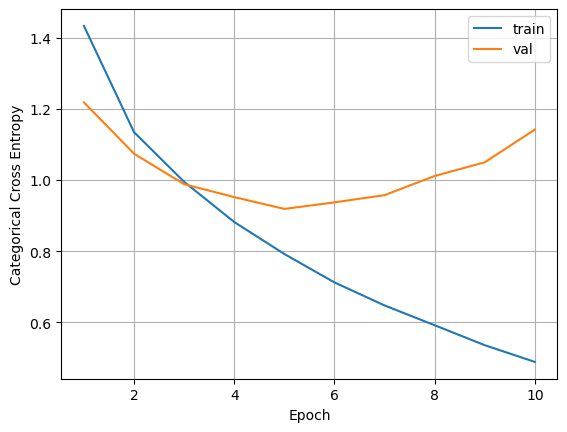

In [17]:
plt.plot(range(1, 11), model2.history.history['loss'], label='train')
plt.plot(range(1, 11), model2.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def as_input(string):
    return pad_sequences(np.array([[word2idx[w] for w in TreebankWordTokenizer().tokenize(string.lower())]]), max_words)

In [ ]:
model2.predict(as_input('This food is so bad'))

1/1 [==============================] - 0s 51ms/step


array([[0.26884702, 0.19408835, 0.18528415, 0.16085261, 0.1909278 ]],
      dtype=float32)

In [ ]:
model2.predict(as_input('This food is so good'))

1/1 [==============================] - 0s 57ms/step


array([[0.12348532, 0.13143587, 0.15475208, 0.25321314, 0.33711362]],
      dtype=float32)

In [ ]:
model2.predict(as_input('One of the worst places Ive been, unfortunately! Rude staff, horrible service and tasteless food and coffee. Would never come back or recommend this place.'))

1/1 [==============================] - 0s 48ms/step


array([[9.0595245e-01, 8.9305595e-02, 4.4571133e-03, 9.4432340e-05,
        1.9043012e-04]], dtype=float32)

In [ ]:
model2.evaluate(test_data)

## Sentiment Analysis with Hugging Face Model

In [19]:
df = pd.read_csv("data/review1.csv")

In [20]:
cls = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [21]:
for i in range(5):
  print(df['text'][i])
  print()

Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry and korma.  With 10 different kinds of naan!!!  Don't let the outside deter you (because we almost changed our minds)...go in and try something new!   You'll be glad you did!

I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) and was told they're too busy to do it. Really? The place is maybe half full at best. Does your dick reach your ass? Yes? Go fuck yourself! I'm a frequent customer AND great tipper. Glad that Kanella just opened. NEVER going back to dmitris!

Good food--loved the gnocchi with marinara
the baked eggplant appetizer was very good too

The service was very slow, but despite this, I'd go back, the food is just that good

Tremendous service (Big shout out to Douglas) that complemented the delicious food. Pretty expensive establishment (40-50$ avg for your main course), but its definitely backs that up with an atmosphere that's comparable with any of the

In [22]:
# Need to truncate data to be able to predict on everything
cls(list(df['text'][0:5]))

[{'label': 'POSITIVE', 'score': 0.9997116923332214},
 {'label': 'NEGATIVE', 'score': 0.997217059135437},
 {'label': 'POSITIVE', 'score': 0.9995474219322205},
 {'label': 'POSITIVE', 'score': 0.9997289776802063},
 {'label': 'POSITIVE', 'score': 0.9997133612632751}]